# Airline Review Sentiment Analysis
***
**Author:** Ron Lodetti Jr.
![doctor](./images/doctor_crop.jpg)

Image by <a href="https://www.freepik.com/free-photo/doctor-checking-radiography-front-view_35436186.htm#fromView=search&page=1&position=0&uuid=0c377c4a-a764-4319-8c20-d708851a4835">Freepik</a>

## Overview
***

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem
***

A popular airline company wants to increase customer sentiment and foster loyalty through improving customer service. Some difficulties include the many different areas the company could focus on, such as flight attendant training, food quality, seat comfort, as well as the challenge of manually reviewing survey data.

The airline has tasked me with analyzing over 20,000 historical reviews to help predict customer satisfaction and identify the most influential features responsible for customer satisfaction.

By creating a predictive model to analyze customer sentiment at scale, our project aims to provide the airline with the insights needed to make informed decisions, ultimately improving the customer experience, fostering loyalty, and enhancing the brand's competitive edge in the market.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from tensorflow.data import AUTOTUNE as tf_AUTOTUNE, Dataset as tf_Dataset
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, GRU, TextVectorization
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from src import code

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

STOPWORDS = stopwords.words('english')
%load_ext autoreload
%autoreload 2

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logging (1: INFO, 2: WARNING, 3: ERROR)
import warnings
warnings.filterwarnings('ignore')  # Suppress Python warnings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Understanding

The original dataset was collected from from [airlineequallity.com](https://www.airlinequality.com/review-pages/a-z-airline-reviews/) by 
Juhi Bhojani. You can find more details about their collection process at their [GitHub](https://github.com/Juhibhojani/Airline-Reviews-). I found and downloaded the data directly from [Kaggle](https://www.kaggle.com/datasets/juhibhojani/airline-reviews) in the form of a csv. 

While originally including 20 columns, I decided to select just 3 of them to focus this project on Natual Language Processing. The `Review_Title` and `Review` columns will be combined to serve as the review texts and the target will be the `Recommended` column which consists of either "yes" or "no". 

Data Understanding: Notebook clearly describes the source and properties of the data to show how useful the data are for solving the problem of interest.
Describe the data sources and explain why the data are suitable for the project
Present the size of the dataset and descriptive statistics for all features used in the analysis
Justify the inclusion of features based on their properties and relevance for the project
Identify any limitations of the data that have implications for the project

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***


In [3]:
df = pd.read_csv('data/Airline_review.csv')[['Review_Title','Review','Recommended']]
df.head()

,Review_Title,Review,Recommended
0,"""pretty decent airline""",Moroni to Moheli. Turned out to be a pretty ...,yes
1,"""Not a good airline""",Moroni to Anjouan. It is a very small airline...,no
2,"""flight was fortunately short""",Anjouan to Dzaoudzi. A very small airline an...,no
3,"""I will never fly again with Adria""",Please do a favor yourself and do not fly wi...,no
4,"""it ruined our last days of holidays""",Do not book a flight with this airline! My fr...,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_Title  23171 non-null  object
 1   Review        23171 non-null  object
 2   Recommended   23171 non-null  object
dtypes: object(3)
memory usage: 543.2+ KB


In [6]:
df['reviews'] = df['Review_Title'] + ' ' + df['Review']

tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
df['clean_review'] = code.preprocess_texts(df['reviews'], tokenizer)
df['tokens'] = df['clean_review'].apply(lambda x : x.split())
df['word_count'] = df['tokens'].apply(lambda x: len(x))
df['char_count'] = df['clean_review'].apply(lambda x: len(x))
df = df.drop(['Review_Title','Review','reviews'],axis=1)

In [7]:
yes_df = df.loc[df['Recommended']=='yes'].copy()
no_df = df.loc[df['Recommended']=='no'].copy()

In [8]:
# Number and distribution of target
display(df['Recommended'].value_counts())
print('')
display(df['Recommended'].value_counts(normalize=True))

Recommended
no     15364
yes     7807
Name: count, dtype: int64

Recommended
no     0.66307
yes    0.33693
Name: proportion, dtype: float64

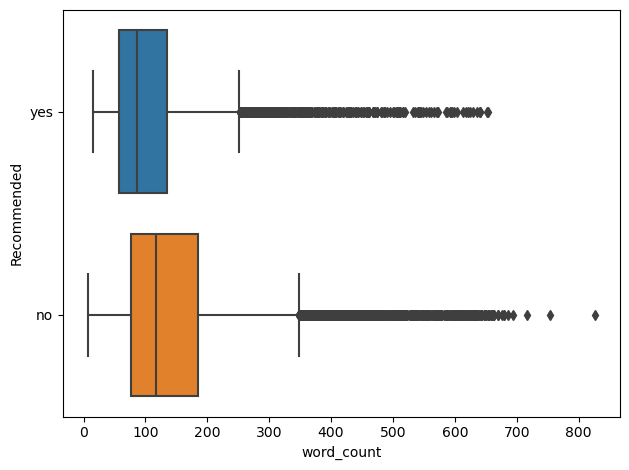

In [14]:
sns.boxplot(data=df, x='word_count', y='Recommended', hue='Recommended',dodge=False)
plt.legend().remove()
plt.tight_layout()
plt.show()

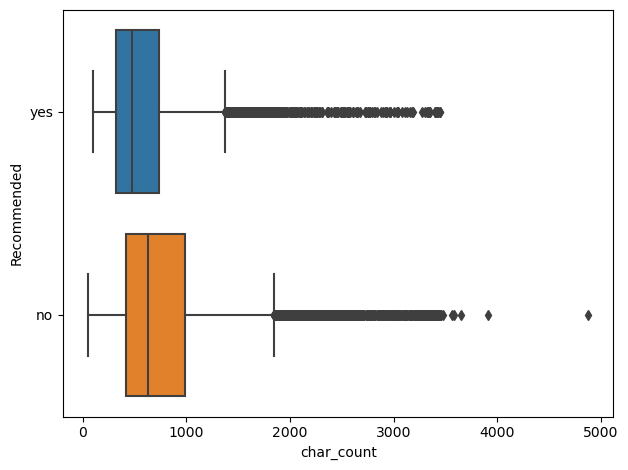

In [15]:
sns.boxplot(data=df, x='char_count', y='Recommended', hue='Recommended',dodge=False)
plt.legend().remove()
plt.tight_layout()
plt.show()

### Stopped & Lemmatized Data

In [ ]:

stopped_df = pd.read_csv('data/Airline_review.csv')[['Review_Title','Review','Recommended']]
stopped_df['reviews'] = stopped_df['Review_Title'] + ' ' + stopped_df['Review']
stopped_df['tokens'] = code.preprocess_texts(stopped_df['reviews'], tokenizer, stop_words=STOPWORDS, lemmatize=True, tokenize=True)
yes_stopped_df = stopped_df.loc[stopped_df['Recommended']=='yes'].copy()
no_stopped_df = stopped_df.loc[stopped_df['Recommended']=='no'].copy()
yes_tokens = list(yes_stopped_df['tokens'].explode())
no_tokens = list(no_stopped_df['tokens'].explode())
freq_yes = FreqDist(yes_tokens)
freq_no = FreqDist(no_tokens)
distinct_yes = {word: freq_yes[word] - freq_no[word] for word in freq_yes}
distinct_no = {word: freq_no[word] - freq_yes[word] for word in freq_no}
distinct_yes_fd = FreqDist(distinct_yes)
distinct_no_fd = FreqDist(distinct_no)
common_yes = distinct_yes_fd.most_common(10)
common_no = distinct_no_fd.most_common(10)

In [16]:
from collections import Counter
STOPWORDS.append("us")
STOPWORDS.append("u")
# Combine title and review, then preprocess and tokenize
df['stopped_tokens'] = code.preprocess_texts(df['clean_review'],
                                             tokenizer, 
                                             stop_words=STOPWORDS, 
                                             lemmatize=True, 
                                             tokenize=True)

NameError: name 'stopped_df' is not defined

In [17]:
# Split based on recommendation
yes_tokens = df.loc[df['Recommended'] == 'yes', 'stopped_tokens'].explode()
no_tokens = df.loc[df['Recommended'] == 'no', 'stopped_tokens'].explode()

# Calculate frequencies
freq_yes = Counter(yes_tokens)
freq_no = Counter(no_tokens)

# Find distinct terms by subtracting the counters
distinct_yes = freq_yes - freq_no
distinct_no = freq_no - freq_yes

# Get the most common terms
common_yes = distinct_yes.most_common(10)
common_no = distinct_no.most_common(10)

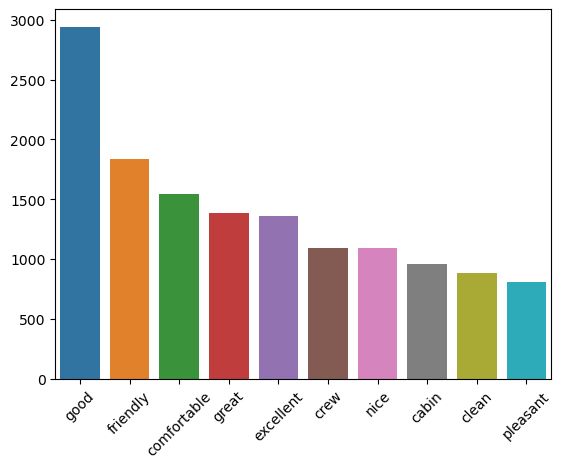

In [18]:
words = []
counts = []
for word, count in common_yes:
    words.append(word)
    counts.append(count)

fig, ax = plt.subplots()
sns.barplot(x=words, y=counts, ax= ax)
plt.xticks(rotation=45)
plt.show()

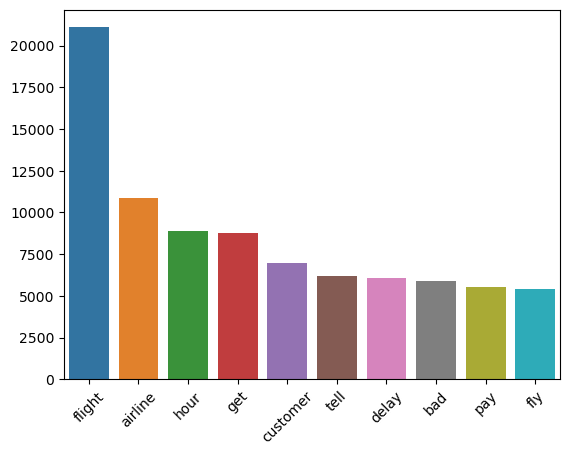

In [19]:
words = []
counts = []
for word, count in common_no:
    words.append(word)
    counts.append(count)

fig, ax = plt.subplots()
sns.barplot(x=words, y=counts, ax= ax)
plt.xticks(rotation=45)
plt.show()

## Data Preparation
***

To prepare my data for modeling I:
- Reorganized the image files.
- Imported my training data, standardizing aspect ratio.
- Applied scaling to the training data for normalization.
- Imported validation data to be used test the model's performance.
- Created a specialized dataset specifically formatted for use with the ResNet50 classifier.

In [33]:
df = pd.read_csv('data/Airline_review.csv')[['Review_Title', 'Review', 'Recommended']]
X = df['Review_Title'] + ' ' + df['Review']
y = df['Recommended'].map({'yes': 1, 'no': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

### Bag of Words Prep

In [34]:
tf_idf = TfidfVectorizer(decode_error='replace',
                         strip_accents='unicode',
                         stop_words=None,
                         ngram_range=(1, 2),
                         max_df=0.95,
                         min_df=2)
k_best = SelectKBest(k=20000)

# def to_dense(x):
#     """Convert a sparse matrix to a dense numpy array."""
#     return np.asarray(x.todense())
    
# to_dense_transformer = FunctionTransformer(to_dense, accept_sparse=True)

# bow_pipe = Pipeline([
#     ("tf_idf", tf_idf),
#     ('feature_selection', k_best),
#     ('to_dense',to_dense_transformer)])

bow_pipe = Pipeline([
    ("tf_idf", tf_idf),
    ('feature_selection', k_best)])

X_train_bow = code.preprocess_texts(X_train, tokenizer, stop_words=None, lemmatize=True)
X_val_bow = code.preprocess_texts(X_val, tokenizer, stop_words=None, lemmatize=True)

In [35]:
# Cleaning text for sequence models
X_train_seq = code.preprocess_texts(X_train, tokenizer)
X_val_seq = code.preprocess_texts(X_val, tokenizer)

In [36]:
# Prep for RNN
text_vectorization = TextVectorization(standardize=None,
                                       max_tokens=20000,
                                       output_mode='int',
                                       output_sequence_length=200)

text_vectorization.adapt(X_train_seq)
X_train_seq_clean = text_vectorization(X_train_seq)
X_val_seq_clean = text_vectorization(X_val_seq)

In [37]:
# Prep for Glove
vocabulary = text_vectorization.get_vocabulary()
vocab_size = len(vocabulary) 

glove_embeddings = {}
with open('data/glove.6B.300d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Initialize the embedding matrix with zeros.
embedding_matrix = np.zeros((vocab_size, 300))

# Populate the embedding matrix with GloVe vectors.
for i, word in enumerate(vocabulary):
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Data Modeling
***

During the modeling process, I iteratively trained and evaluated numerous models to identify the most effective one. A validation dataset, previously unseen by the model, was used for evaluation to ensure accuracy in real-world scenarios. To inform my decision-making, I relied on both loss and recall metrics, aiming to minimize error while maximizing the model's ability to correctly identify pneumonia cases. I also included the Area Under the ROC Curve (AUC) to provide insight into the model's overall performance, ensuring it doesn't just achieve high recall by simply labeling all cases as positive.

Key adjustments made during model iterations and hyperparameter tuning included:

- Adjusting the number and configuration of layers and nodes.
- Choosing between Dense and Conv2D layers for structure.
- Implementing regularization techniques such as Dropout layers, L1/L2 regularization, and data augmentation to prevent overfitting.
- Selecting appropriate initializers and optimizers for optimization.
- Applying transfer learning with the pretrained ResNet50 model to leverage pre-existing neural network architectures.

In [38]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

text_vec_cv = TextVectorization(
    standardize=None,
    max_tokens=20000,
    output_mode='int',
    output_sequence_length=200)

CALLBACKS = [EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=5,
                           restore_best_weights=True,
                           verbose=0)]

### Baseline Models

In [39]:
# Dummy Model
dummy_model = DummyClassifier(strategy='uniform', random_state=42)

def bag_of_words_CV(model_name, model, pipe, X_train, y_train, cv):
    model_pipeline = Pipeline(
        steps=pipe.steps + [
            (model_name, model)
        ]
    )
    cv_results = cross_validate(model_pipeline, 
                            X_train, 
                            y_train, 
                            cv=cv, 
                            scoring=['accuracy', 'roc_auc'], 
                            return_train_score=False)
    
    model_pipeline.fit(X_train, y_train)
    
    dump(model_pipeline,'data/' + model_name + '_pipeline.joblib')
    
    accuracy = cv_results['test_accuracy'].mean()
    auc = cv_results['test_roc_auc'].mean()
    df = pd.DataFrame([[accuracy,auc]],columns=['Accuracy','AUC'], index=[model_name])
    return df

bag_of_words_CV('Dummy', dummy_model, bow_pipe, X_train_bow, y_train, cv=skf)

,Accuracy,AUC
Dummy,0.499832,0.5


In [40]:
baseline_model = LogisticRegression(max_iter=1000)

code.bag_of_words_CV('Baseline', baseline_model, bow_pipe, X_train_bow, y_train, cv=skf)

,Accuracy,AUC
Baseline,0.904762,0.961384


### Bag of Words Models

In [41]:
log_reg = LogisticRegression(C=9.42012179027564, 
                         max_iter= 100, 
                         solver= 'newton-cg')

code.bag_of_words_CV('Logistic_Regression', log_reg, bow_pipe, X_train_bow, y_train, cv=skf)

,Accuracy,AUC
Logistic_Regression,0.916079,0.967629


In [42]:
mnb_model = MultinomialNB(fit_prior= False,
                    class_prior= None,
                    alpha= 0.01)

code.bag_of_words_CV('MultinomialNB', mnb_model, bow_pipe, X_train_bow, y_train, cv=skf)

,Accuracy,AUC
MultinomialNB,0.887738,0.948371


In [43]:
gbc_model = GradientBoostingClassifier(subsample=0.8,
                                 n_estimators=300,
                                 min_samples_split=2,
                                 max_features='sqrt',
                                 max_depth=6,
                                 learning_rate=0.1)

code.bag_of_words_CV('Gradient_Boosting_Classifier', gbc_model, bow_pipe, X_train_bow, y_train, cv=skf)

,Accuracy,AUC
Gradient_Boosting_Classifier,0.902412,0.959359


In [44]:
rfc_model = RandomForestClassifier(n_estimators=500,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_depth=None,
                             bootstrap=True)

code.bag_of_words_CV('Random_Forest_Classifier', rfc_model, bow_pipe, X_train_bow, y_train, cv=skf)

KeyboardInterrupt: 

In [ ]:
def mlp_model_builder():
    model = Sequential([
        Dense(128, activation='relu',input_shape=(20000,)),
        Dropout(0.8),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])
    return model

mlp_model = KerasClassifier(model=mlp_model_builder, 
                           random_state=42,
                           batch_size=256,
                           verbose=0,
                           callbacks=CALLBACKS, 
                           validation_split=0.1,
                           shuffle=True,
                           epochs=100)

code.bag_of_words_CV('Multi-Layer_Perceptrons', mlp_model, bow_pipe, X_train_bow, y_train, cv=skf)

### Sequence Models

In [ ]:
rnn_model = Sequential([
    Embedding(input_dim=20000, output_dim=32, input_length=200),
    Bidirectional(GRU(16)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
    ])

rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

rnn_model.fit(x=X_train_seq_clean,
              y=y_train,
              batch_size=256,
              epochs=100,
              verbose=0,
              validation_split=0.1,
              callbacks=CALLBACKS,
              shuffle=True)

rnn_model.save('rnn_model')

code.keras_cv('RNN',
              X_train,
              y_train,
              skf,
              tokenizer,
              text_vec_cv,
              CALLBACKS)

In [ ]:
glv_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=300, input_length=200, weights=[embedding_matrix], trainable=False),
    Bidirectional(GRU(32)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
    ])

glv_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

glv_model.fit(x=X_train_seq_clean,
              y=y_train,
              batch_size=64,
              epochs=100,
              verbose=0,
              callbacks=CALLBACKS,
              shuffle=True)

glv_model.save('glv_model')

code.keras_cv('GloVe',
              X_train,
              y_train,
              skf,
              tokenizer,
              text_vec_cv,
              CALLBACKS,
              glove=True, 
              glove_path = '../data/glove.6B.300d.txt')

## Evaluation
***

In [ ]:
X_test_bow = code.preprocess_texts(X_test, tokenizer, stop_words=None, lemmatize=True)

In [2]:
from joblib import load
dummy_model = load('dummy_pipeline.joblib')
baseline_model = load('baseline_pipeline.joblib')
final_model = load('mlp_pipeline.joblib')

AttributeError: Can't get attribute 'to_dense' on <module '__main__'>

In [43]:
# Dictionary mapping model names to their corresponding model and test dataset
models_dict = {
    'Dummy Model': [baseline_model, test_ds],
    'Baseline Model': [baseline_model, test_ds],
    'MLP Model': [overfit_model, test_ds],
}

# Initialize an empty list to hold evaluation scores for each model
scores_list = []

# Iterate through the models dictionary to evaluate each model
# and collect their  scores
for model_name, (model, test_dataset) in models_dict.items():
    scores = evaluate_model(model, test_dataset)
    scores_list.append(scores)

# Create a DataFrame to summarize the scores for each model
summary_df = pd.DataFrame(scores_list, 
                          columns=['Test Accuracy','Test AUC'],
                          index=models_dict.keys())

# Display the summary DataFrame
display(summary_df)

,Test Loss,Test Recall,Test AUC
Baseline Model,0.2914,0.8388,0.9449
Overfit Model,0.3313,0.9579,0.9666
Resnet Model,0.3291,0.9299,0.9327
Final Model,0.1089,0.9720,0.9911


In [42]:
def evaluate_model(model, test_dataset):
    """
    Evaluates a given model on a test dataset and returns scores for loss, recall, and AUC.
    """
    # Evaluate the model on the test dataset
    test_scores = model.evaluate(test_dataset, verbose=0)

    # Initialize an empty list to hold scores
    scores = []

    # Indices for loss, recall, and AUC in `test_scores` are 0, 2, and 1, respectively.
    # Appending rounded scores for loss, recall, and AUC to the scores list
    for index in [0, 2, 1]:
        scores.append(round(test_scores[index], 4))
        
    return scores


19/19 [==============================] - 1s 34ms/step


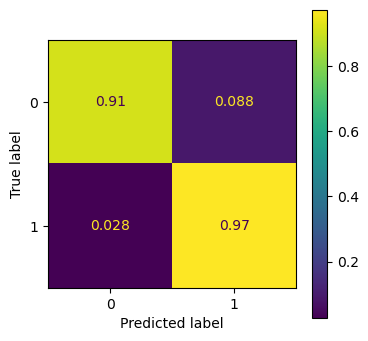

In [44]:
data_modeling.cnf_mat(dropout_model, test_ds)

The final model demonstrated exceptional performance on the unseen test dataset, achieving a recall of 97.2% and an AUC of 99.11%. These results indicate a high ability to correctly identify pneumonia cases, with the model correctly identifying 97.2% of all pneumonia images. The strong performance across validation and testing datasets suggests that the model is likely to generalize well to new, unseen data

## Conclusions
***
### Recommendations
Based on the final model, it is recommended that the children's hospital consider incorporating this model into their pneumonia diagnosis workflow. Initially, radiologists and the model should independently evaluate chest X-rays, with their diagnoses being compared to assess the model's reliability and accuracy. Over time, as confidence in the model's diagnostic capabilities grows, the hospital could gradually shift more responsibility to the model. This approach aims to not only enhance diagnostic efficiency but also improve accuracy, ultimately benefiting patient care.

### Limitations
- Although a 97% accuracy rate is impressive, it implies that 3% of patients with the condition are misdiagnosed as healthy.
- Given that the images in this dataset underwent initial quality control, removing low-quality and unreadable scans, the model is likely most effective with high-quality images.
  
### Next Steps
- Encourage increased use of chest X-ray imaging, as the cost to diagnose images has decreased.
- Continuously update the training sets with new images to refine and improve model accuracy.
- Instead of a binary classifier, future models could be made to detect bacterial vs viral pneumonia cases. 